# Caso Práctico de Clustering con DBSCAN

### Breve resumen del algoritmo

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering basado en la densidad, y a diferencia de otros, no requiere que se especifique el número de clústeres por adelantado. En lugar de eso, define clústeres como áreas de alta densidad separadas por áreas de baja densidad, lo que le permite identificar clústeres de diferentes formas y tamaños a partir de una gran cantidad de datos, y es robusto ante ruido y valores atípicos.
El algoritmo requiere dos parámetros principales: ε (epsilon), que especifica el radio alrededor de un punto, y el número mínimo de puntos requeridos para formar una región densa (minPts).
Esto hace que DBSCAN sea particularmente útil para aplicaciones donde la forma y el número de clústeres no se conocen de antemano, y cuando se espera la presencia de ruido y valores atípicos en los datos.

## Detección de transacciones bancarias fraudulentas con tarjetas de crédito

### Descripción del conjunto de datos
El conjunto de datos contiene transacciones realizadas con tarjetas de crédito en septiembre de 2023 por titulares europeos. En este conjunto, se registran transacciones que tuvieron lugar en dos días, con 9,057 casos de fraude de un total de 123,304 transacciones, lo que representa solo el 7.35% de todas las transacciones. Las variables de entrada son exclusivamente numéricas, resultado de una transformación PCA. Por razones de confidencialidad, no se pueden proporcionar las características originales ni más información de fondo sobre los datos. Las características V1 a V28 son los componentes principales; la única característica que no ha sido transformada con PCA es'Amount'. La característica 'Amount' es el monto de la transacción. La variable 'Class' es la variable a predecir, tomando el valor 1 en caso de fraude y 0 en caso contrario.

### Fuente del fichero de datos
Los datos fueron extraídos de https://www.kaggle.com/ y editados para disminuir la tasa de fraude, que originalmente representaba el 50% del total.

## Librerías utilizadas

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
import warnings

%matplotlib inline
warnings.simplefilter("ignore")

## 1. Lectura del conjunto de datos

Se utiliza la librería pandas para importar los datos en formato "csv"

In [2]:
df = pd.read_csv("dataset/creditcard2023.csv")

## 2. Comprensión del conjunto de datos

### 2.1. Vista preliminar

In [3]:
df.head(8)

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1,0.985,-0.356,0.558,-0.430,0.277,0.429,0.406,-0.133,0.347,...,-0.195,-0.606,0.079,-0.577,0.190,0.297,-0.248,-0.065,6531.37,0
1,3,-0.152,-0.509,1.747,-1.090,0.249,1.143,0.518,-0.065,-0.206,...,-0.147,-0.038,-0.214,-1.893,1.004,-0.516,-0.165,0.048,5384.44,0
2,6,1.016,-0.397,0.498,-0.144,0.331,0.629,0.431,-0.134,0.796,...,-0.171,-0.287,-0.178,-1.298,1.183,-0.604,-0.198,-0.088,18954.45,0
3,8,-0.131,-0.350,0.426,-0.760,1.703,2.325,0.569,0.049,0.273,...,-0.133,-0.285,-0.228,2.249,0.535,-0.930,-0.224,0.244,22052.90,0
4,12,1.034,-0.902,0.677,-1.319,-0.216,0.025,0.223,-0.203,-0.502,...,-0.197,-0.473,0.062,0.833,0.180,-0.854,-0.208,0.002,21696.89,0
5,15,-0.087,-0.330,2.000,-1.471,-0.126,0.431,0.245,-0.152,0.250,...,0.092,1.303,-0.279,-0.086,-0.147,-0.188,-0.437,0.212,23472.79,0
6,17,0.021,-0.153,1.029,-1.010,0.668,0.402,0.707,-0.132,0.132,...,-0.182,-0.635,-0.181,-1.465,-0.629,-0.099,-0.145,0.216,15493.04,0
7,19,1.245,-0.825,0.719,-1.451,-0.235,0.045,0.120,-0.164,-0.455,...,-0.175,-0.202,0.017,0.628,0.467,-0.512,-0.212,-0.082,2943.42,0


### 2.2. Primeras nociones

##### Características y registros

In [4]:
print("Número de variables predictoras:", len(df.columns))
print("Cantidad de registros:", len(df))

Número de variables predictoras: 31
Cantidad de registros: 123304


##### Casos positivos de fraude

In [5]:
print("Cantidad de registros de fraude positivo:", df['Class'].value_counts().get(1))
print("Tasa de fraude:", df["Class"].mean())

Cantidad de registros de fraude positivo: 9057
Tasa de fraude: 0.07345260494387855


##### Tipo de datos de las variables predictoras

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123304 entries, 0 to 123303
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      123304 non-null  int64  
 1   V1      123304 non-null  float64
 2   V2      123304 non-null  float64
 3   V3      123304 non-null  float64
 4   V4      123304 non-null  float64
 5   V5      123304 non-null  float64
 6   V6      123304 non-null  float64
 7   V7      123304 non-null  float64
 8   V8      123304 non-null  float64
 9   V9      123304 non-null  float64
 10  V10     123304 non-null  float64
 11  V11     123304 non-null  float64
 12  V12     123304 non-null  float64
 13  V13     123304 non-null  float64
 14  V14     123304 non-null  float64
 15  V15     123304 non-null  float64
 16  V16     123304 non-null  float64
 17  V17     123304 non-null  float64
 18  V18     123304 non-null  float64
 19  V19     123304 non-null  float64
 20  V20     123304 non-null  float64
 21  V21     12

##### Análisis de valores perdidos

Ninguna de las variables contiene valores perdidos, nulos o infinitos.

In [7]:
df.isna().any()

id        False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

##### Análisis descriptivo del DataFrame

In [8]:
# No aporta demasiada información ya que las variables se encuentran tranformadas
df.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,...,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000,123304.000000
mean,163559.392364,0.429088,-0.420031,0.582450,-0.628816,0.291769,0.372807,0.420085,-0.123824,0.499629,...,-0.093957,-0.011291,-0.007687,0.110104,-0.051599,-0.054920,-0.181616,-0.089680,12029.085584,0.073453
std,110582.440644,0.869564,0.777474,0.789638,0.773328,0.720002,0.784062,0.650229,0.440822,0.807921,...,0.465837,0.726441,0.696163,1.113041,0.865448,1.071021,0.571369,0.783815,6925.966837,0.260879
min,1.000000,-3.219000,-42.460000,-2.631000,-4.834000,-5.183000,-15.512000,-4.325000,-10.756000,-3.752000,...,-19.383000,-7.735000,-30.295000,-4.051000,-13.613000,-8.227000,-6.061000,-24.176000,50.380000,0.000000
25%,77233.000000,-0.179000,-0.639000,0.071000,-1.047000,-0.016000,-0.025000,0.231000,-0.198000,0.076000,...,-0.194000,-0.520000,-0.192000,-0.613000,-0.584000,-0.756000,-0.316000,-0.229000,6030.927500,0.000000
50%,154104.500000,0.144000,-0.398000,0.508000,-0.580000,0.219000,0.291000,0.432000,-0.144000,0.430000,...,-0.108000,-0.035000,-0.039000,0.105000,-0.049000,-0.085000,-0.230000,-0.068000,11982.795000,0.000000
75%,230660.250000,1.054000,-0.146000,1.053000,-0.218000,0.514000,0.676000,0.638000,-0.066000,0.850000,...,-0.016000,0.462000,0.130250,0.902000,0.506000,0.564000,-0.103000,0.116000,18038.777500,0.000000
max,568577.000000,2.226000,4.342000,4.615000,3.202000,33.318000,9.704000,41.880000,5.958000,10.375000,...,8.087000,12.633000,31.708000,10.856000,11.558000,5.556000,26.944000,37.268000,24039.930000,1.000000


##### Representación gráfica de cada característica con la variable dependiente

En la gráfica siguiente se puede apreciar las funciones de densidad para cada característica junto con la variable objetivo. Aquellas que posean una mayor distancia en el eje x, serán las más representativas.


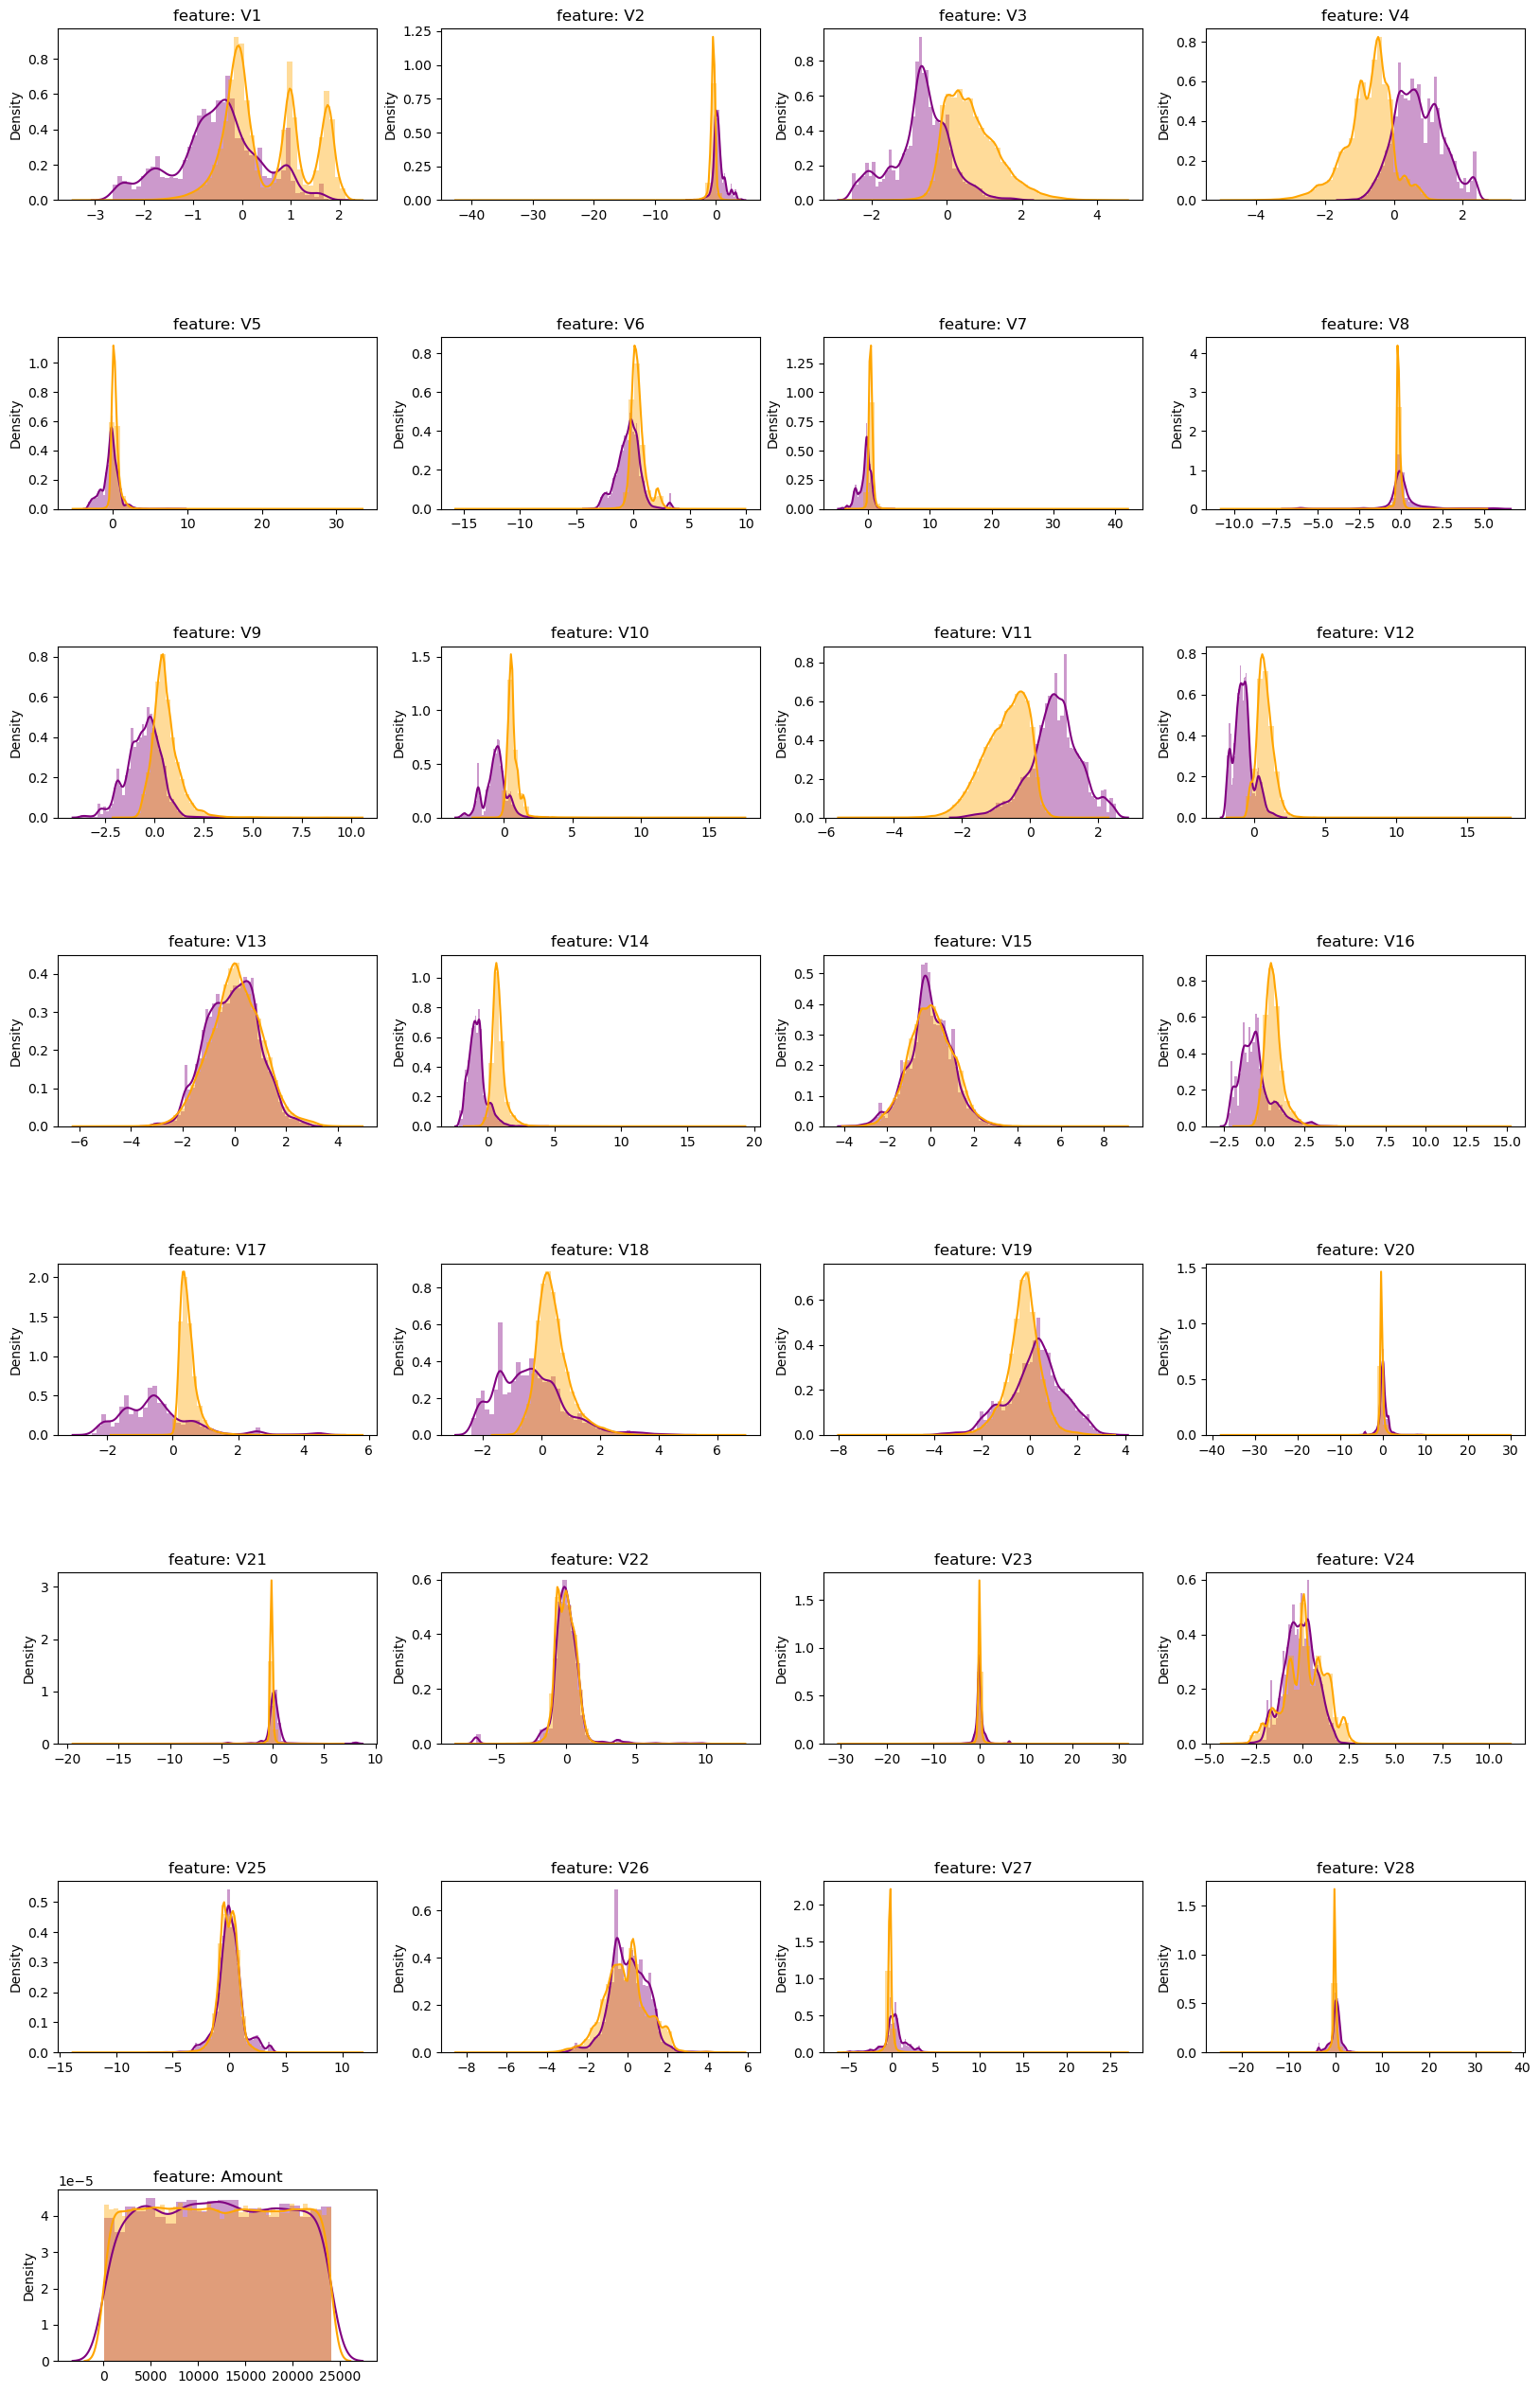

In [9]:
features = df.drop(["Class", "id"] , axis=1)

plt.figure(figsize=(20,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["Class"] == 1], color="purple")
    sns.distplot(df[f][df["Class"] == 0], color="orange", )
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

## 3. Preparación del conjunto de datos

Para respetar la escala de las variables desarrolladas con PCA, no será tenida en cuenta "Amount". También se puede ver en los gráficos anteriores, que no existe una fuerte discriminación respecto a la variable objetivo.

In [10]:
# Separación de variables predictoras de la variable dependiente
X = df.drop(["Amount", "Class", "id"], axis=1)
y = df["Class"].copy()

## 4. Generación del modelo

Como bien se explicó al comienzo del cuaderno, el algoritmo DBSCAN define áreas de alta densidad, separándolas de otras con baja densidad, por lo tanto, a fines prácticos, se utilizarán las variables que se encuentren mayormente superpuestas en el gráfico de dos dimensiones y se buscarán los parámetros óptimos para su entrenamiento.

Los modelos desarrollados serán utilizando 2 variables para su fácil interpretación gráfica, y si bien se puede aumentar la cantidad, no se recomienda el entrenamiento con una gran cantidad.

### 4.1 DBSCAN con dos variables - Primer caso:

In [11]:
X = df[["V22", "V25"]].copy()

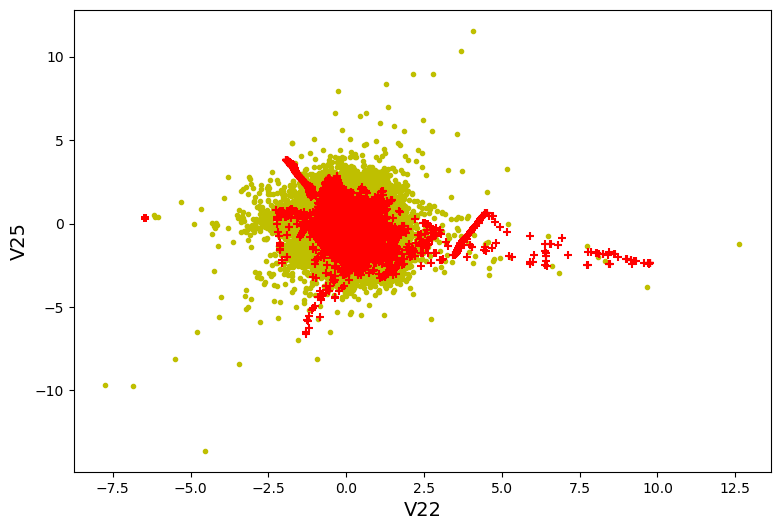

In [12]:
# Representación gráfica
plt.figure(figsize=(9, 6))
plt.scatter(df["V22"][df['Class'] == 0], df["V25"][df['Class'] == 0], c="y", marker=".")
plt.scatter(df["V22"][df['Class'] == 1], df["V25"][df['Class'] == 1], c="r", marker="+")
plt.xlabel("V22", fontsize=14)
plt.ylabel("V25", fontsize=14)
plt.show()

#### 4.1.1 Entrenamiento

In [13]:
X.name = None
X = X.to_numpy()

In [14]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.16, min_samples=35)
dbscan.fit(X)

DBSCAN(eps=0.16, min_samples=35)

#### 4.1.2 Resultados

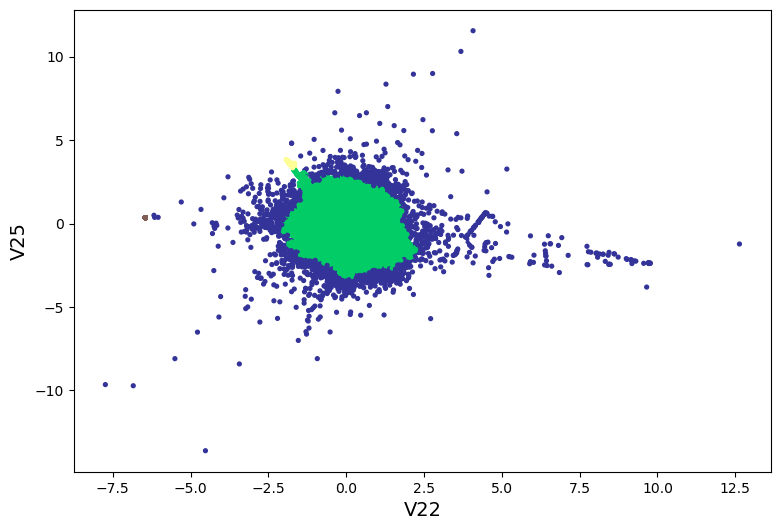

In [15]:
plt.figure(figsize=(9, 6))
plt.scatter(X[:,0], X[:,1], c=dbscan.labels_, cmap='terrain', marker='.', s=30)
plt.xlabel("V22", fontsize=14)
plt.ylabel("V25", fontsize=14)
plt.show()

In [16]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} casos y {2} son fraude (porcentaje {3}%)".format(
        key, counter[key], bad_counter[key], round(bad_counter[key]*100/counter[key],2)))

Cluster -1 tiene 1811 casos y 288 son fraude (porcentaje 15.9%)
Cluster 0 tiene 121221 casos y 8498 son fraude (porcentaje 7.01%)
Cluster 1 tiene 118 casos y 117 son fraude (porcentaje 99.15%)
Cluster 2 tiene 106 casos y 106 son fraude (porcentaje 100.0%)
Cluster 3 tiene 48 casos y 48 son fraude (porcentaje 100.0%)


### 4.2 DBSCAN con dos variables - Segundo caso:

#### 4.2.1 Entrenamiento

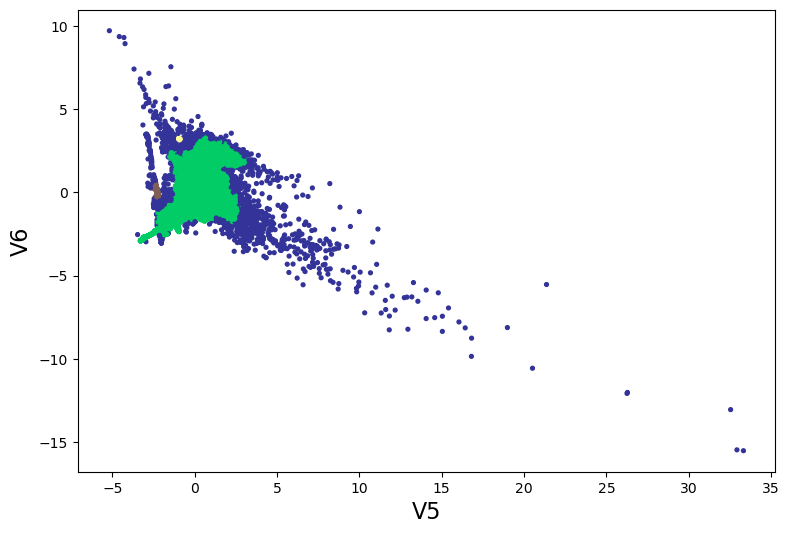

Cluster -1 tiene 1461 casos y 378 son fraude (porcentaje 25.87%)
Cluster 0 tiene 121571 casos y 8414 son fraude (porcentaje 6.92%)
Cluster 1 tiene 111 casos y 106 son fraude (porcentaje 95.5%)
Cluster 2 tiene 98 casos y 96 son fraude (porcentaje 97.96%)
Cluster 3 tiene 63 casos y 63 son fraude (porcentaje 100.0%)


In [17]:
X = df[["V5", "V6"]].copy()
y = df["Class"].copy()

X.name = None
X = X.to_numpy()

dbscan = DBSCAN(eps=0.16, min_samples=24)
dbscan.fit(X)

plt.figure(figsize=(9, 6))
plt.scatter(X[:,0], X[:,1], c=dbscan.labels_, cmap='terrain', marker='.', s=30)
plt.xlabel("V5", fontsize=16)
plt.ylabel("V6", fontsize=16)
plt.show()

#### 4.2.2 Resultados

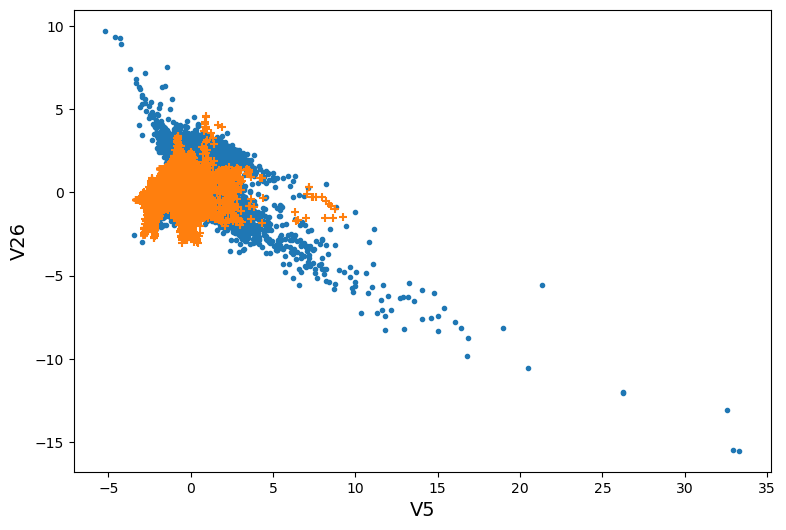

Cluster -1 tiene 1461 casos y 378 son fraude (porcentaje 25.87%)
Cluster 0 tiene 121571 casos y 8414 son fraude (porcentaje 6.92%)
Cluster 1 tiene 111 casos y 106 son fraude (porcentaje 95.5%)
Cluster 2 tiene 98 casos y 96 son fraude (porcentaje 97.96%)
Cluster 3 tiene 63 casos y 63 son fraude (porcentaje 100.0%)


In [19]:
# Representación gráfica
plt.figure(figsize=(9, 6))
plt.scatter(df["V5"][df['Class'] == 0], df["V6"][df['Class'] == 0], marker=".")
plt.scatter(df["V5"][df['Class'] == 1], df["V26"][df['Class'] == 1], marker="+")
plt.xlabel("V5", fontsize=14)
plt.ylabel("V26", fontsize=14)
plt.show()

counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} casos y {2} son fraude (porcentaje {3}%)".format(
        key, counter[key], bad_counter[key], round(bad_counter[key]*100/counter[key],2)))